In [27]:
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
from pathlib import Path

In [29]:
from zod import ZodDataset, ZodFrame, ZodFrames
from zod import AnnotationProject

dataset_fold

In [30]:
dataset_dir = "single_frames"
log_id = "007674"

log_dir = Path(dataset_dir) / log_id
assert log_dir.exists(), f"Log directory {log_dir} does not exist."

In [31]:
# load one log dir
def load_log_data(log_id):
    frames = ZodFrames(".", version="mini")
    frame = frames[log_id]
    
    image = frame.get_image()
    obj_list = frame.get_annotation(AnnotationProject.OBJECT_DETECTION)
    ts_list = frame.get_annotation(AnnotationProject.TRAFFIC_SIGNS)
    lm_list = frame.get_annotation(AnnotationProject.LANE_MARKINGS)
    
    oxts = frame.oxts
    
    return {
        "image": image,
        "obj_list": obj_list,
        "ts_list": ts_list,
        "lm_list": lm_list,
        "oxts": oxts,
    }

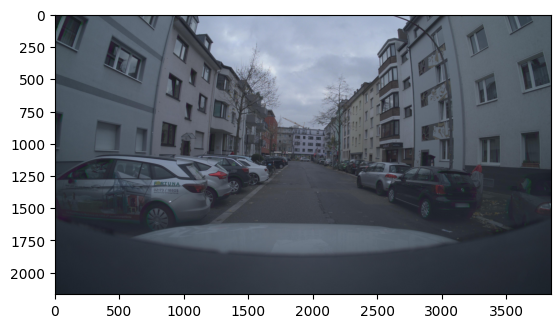

In [32]:
log_data = load_log_data(log_id)
plt.imshow(log_data["image"])

In [33]:
def plot_objs_on_image(image, obj_list):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for obj in obj_list:
        bbox = obj.box2d.xyxy  # numpy array: [x1, y1, x2, y2]
        rect = plt.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            color="red",
            linewidth=2,
        )
        ax.add_patch(rect)
        ax.text(
            bbox[0],
            bbox[1],
            getattr(obj, "object_type", getattr(obj, "category", "")),
            color="yellow",
            fontsize=12,
            backgroundcolor="black",
        )
    ax.axis("off")
    fig.tight_layout(pad=0)
    # Return the figure or the numpy array of the image with bboxes
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    img_with_boxes = np.frombuffer(fig.canvas.get_renderer().buffer_rgba(), dtype=np.uint8)
    img_with_boxes = img_with_boxes.reshape((height, width, 4))[:, :, :3]  # 去掉alpha通道
    plt.close(fig)
    return img_with_boxes

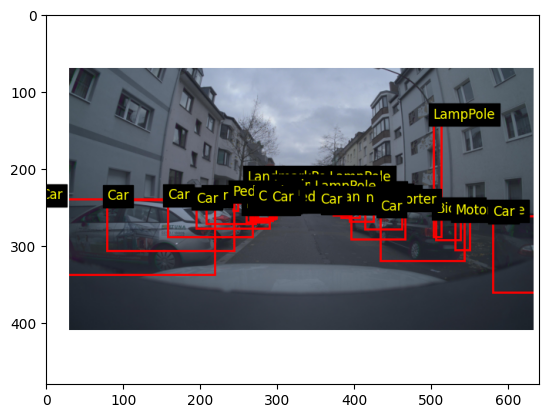

In [34]:
image_objs = plot_objs_on_image(log_data["image"], log_data["obj_list"])
plt.imshow(image_objs)

In [35]:
log_data["ts_list"][0].traffic_sign_class   

'NotListed'

In [36]:
def plot_traffic_signs_on_image(image, ts_list):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for ts in ts_list:
        bbox = ts.bounding_box.xyxy  # numpy array: [x1, y1, x2, y2]
        rect = plt.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            color="blue",
            linewidth=2,
        )
        ax.add_patch(rect)
        ax.text(
            bbox[0],
            bbox[1],
            getattr(ts, "sign_type", ""),
            color="yellow",
            fontsize=12,
            backgroundcolor="black",
        )
    ax.axis("off")
    fig.tight_layout(pad=0)
    # Return the figure or the numpy array of the image with bboxes
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    img_with_boxes = np.frombuffer(fig.canvas.get_renderer().buffer_rgba(), dtype=np.uint8)
    img_with_boxes = img_with_boxes.reshape((height, width, 4))[:, :, :3]  # 去掉alpha通道
    plt.close(fig)
    return img_with_boxes

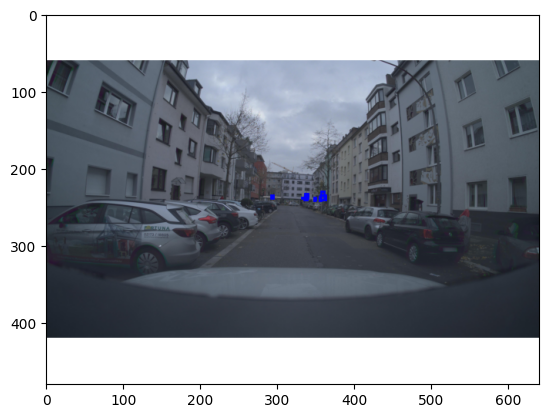

In [37]:
image_ts = plot_traffic_signs_on_image(log_data["image"], log_data["ts_list"])
plt.imshow(image_ts)

In [38]:
# get lon lat

oxts = log_data["oxts"]
lat, lon = oxts.origin_lat_lon
print(lat, lon)

50.931347462545546 6.91432021408007


In [39]:
import osmnx as ox
import matplotlib.pyplot as plt

def create_osmnx_map(lat, lon, dist=1000, save_path='map.png'):
    """
    使用osmnx创建地图
    `
    Parameters:
    lat, lon: 中心点经纬度
    dist: 从中心点开始的距离（米）
    save_path: 保存路径
    """
    # 获取地图数据
    graph = ox.graph_from_point((lat, lon), dist=dist, network_type='all')
    
    # 绘制地图
    fig, ax = ox.plot_graph(graph, show=False, close=False, 
                           node_size=0, edge_linewidth=0.5)
    
    # 添加标记点
    ax.plot(lon, lat, 'ro', markersize=15, label='Origin')
    ax.text(lon, lat + 0.0005, 'Origin', fontsize=12, ha='center', 
            bbox=dict(facecolor='white', alpha=0.7))
    
    # 保存图像
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"地图已保存为: {save_path}")

# 使用示例
create_osmnx_map(lat, lon, dist=2000, save_path='demo.png')

地图已保存为: demo.png


In [40]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

def get_location_info(lat, lon):
    """
    通过经纬度获取位置信息（国家、城市等）
    
    Parameters:
    lat, lon: 经纬度坐标
    
    Returns:
    dict: 包含国家、城市等信息的字典
    """
    # 初始化地理编码器（使用OpenStreetMap的Nominatim服务）
    geolocator = Nominatim(user_agent="location_finder_app")
    
    try:
        # 反向地理编码
        location = geolocator.reverse((lat, lon), exactly_one=True, language='en')
        
        if location:
            address = location.raw.get('address', {})
            return {
                'country': address.get('country', 'Unknown'),
                'country_code': address.get('country_code', 'Unknown'),
                'state': address.get('state', 'Unknown'),
                'city': address.get('city') or address.get('town') or address.get('village') or address.get('county') or 'Unknown',
                'full_address': location.address,
                'raw_data': address
            }
        else:
            return {'error': 'No location found'}
            
    except GeocoderTimedOut:
        return {'error': 'Geocoding service timed out'}
    except GeocoderServiceError as e:
        return {'error': f'Geocoding service error: {e}'}
    except Exception as e:
        return {'error': f'Unexpected error: {e}'}
    
get_location_info(lat, lon)

{'country': 'Germany',
 'country_code': 'de',
 'state': 'North Rhine-Westphalia',
 'city': 'Cologne',
 'full_address': '26, Klosterstraße, Lindenthal, Cologne, North Rhine-Westphalia, 50931, Germany',
 'raw_data': {'house_number': '26',
  'road': 'Klosterstraße',
  'suburb': 'Lindenthal',
  'city_district': 'Lindenthal',
  'city': 'Cologne',
  'state': 'North Rhine-Westphalia',
  'ISO3166-2-lvl4': 'DE-NW',
  'postcode': '50931',
  'country': 'Germany',
  'country_code': 'de'}}

# Retrieval Mapillary Images using GNSS info

In [41]:
import requests
import json
from typing import List, Dict, Optional
import math


In [42]:
mapillary_api = "MLY|7204374579639739|7512e193a8dbb293dd550d05576f9ffa"


In [43]:
class MapillaryImageRetriever:
    def __init__(self, client_id: str):
        """
        初始化Mapillary API客户端
        
        Parameters:
        client_id: 您的Mapillary客户端ID
        """
        self.client_id = client_id
        self.base_url = "https://graph.mapillary.com"
        self.headers = {
            'Authorization': f'OAuth {client_id}'
        }
    
    def search_images_near_location(self, lat: float, lon: float, radius: int = 50, limit: int = 10) -> List[Dict]:
        """
        搜索指定位置附近的图片
        
        Parameters:
        lat, lon: 经纬度坐标
        radius: 搜索半径（米），默认50米
        limit: 返回结果数量，默认10张
        
        Returns:
        图片信息列表
        """
        # Mapillary API端点
        url = f"{self.base_url}/images"
        
        # 查询参数
        params = {
            'fields': 'id,geometry,compass_angle,captured_at,thumb_1024_url,thumb_original_url',
            'bbox': self._create_bbox(lat, lon, radius),
            'limit': limit,
            'access_token': self.client_id
        }
        
        try:
            response = requests.get(url, params=params, headers=self.headers)
            response.raise_for_status()
            
            data = response.json()
            return data.get('data', [])
            
        except requests.exceptions.RequestException as e:
            print(f"API请求错误: {e}")
            return []
        except json.JSONDecodeError as e:
            print(f"JSON解析错误: {e}")
            return []
    
    def _create_bbox(self, lat: float, lon: float, radius: int) -> str:
        """
        创建边界框（Bounding Box）用于搜索
        
        Parameters:
        lat, lon: 中心点坐标
        radius: 半径（米）
        
        Returns:
        边界框字符串格式: min_lon,min_lat,max_lon,max_lat
        """
        # 将米转换为经纬度（近似计算）
        lat_degree = radius / 111320.0  # 1度纬度约111.32公里
        lon_degree = radius / (111320.0 * math.cos(math.radians(lat)))
        
        min_lat = lat - lat_degree
        max_lat = lat + lat_degree
        min_lon = lon - lon_degree
        max_lon = lon + lon_degree
        
        return f"{min_lon},{min_lat},{max_lon},{max_lat}"
    
    def get_closest_image(self, lat: float, lon: float, radius: int = 100) -> Optional[Dict]:
        """
        获取距离指定位置最近的图片
        
        Parameters:
        lat, lon: 目标经纬度
        radius: 搜索半径（米）
        
        Returns:
        最近的图片信息
        """
        images = self.search_images_near_location(lat, lon, radius, limit=20)
        
        if not images:
            return None
        
        # 找到距离最近的图片
        closest_image = None
        min_distance = float('inf')
        
        for image in images:
            img_lon, img_lat = image['geometry']['coordinates']
            distance = self._calculate_distance(lat, lon, img_lat, img_lon)
            
            if distance < min_distance:
                min_distance = distance
                closest_image = image
                closest_image['distance'] = distance  # 添加距离信息
        
        return closest_image
    
    def _calculate_distance(self, lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        """
        计算两个经纬度坐标之间的距离（米）
        使用Haversine公式
        """
        R = 6371000  # 地球半径（米）
        
        lat1_rad = math.radians(lat1)
        lon1_rad = math.radians(lon1)
        lat2_rad = math.radians(lat2)
        lon2_rad = math.radians(lon2)
        
        dlat = lat2_rad - lat1_rad
        dlon = lon2_rad - lon1_rad
        
        a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        
        return R * c
    
    def download_image(self, image_url: str, save_path: str) -> bool:
        """
        下载图片到本地
        
        Parameters:
        image_url: 图片URL
        save_path: 保存路径
        
        Returns:
        是否下载成功
        """
        try:
            response = requests.get(image_url, stream=True)
            response.raise_for_status()
            
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            
            print(f"图片已保存: {save_path}")
            return True
            
        except requests.exceptions.RequestException as e:
            print(f"下载失败: {e}")
            return False
    
    def display_image_info(self, image: Dict):
        """
        显示图片信息
        """
        if not image:
            print("没有找到图片")
            return
        
        print("=" * 50)
        print("📷 图片信息:")
        print(f"ID: {image.get('id')}")
        print(f"拍摄时间: {image.get('captured_at')}")
        print(f"朝向角度: {image.get('compass_angle', 'N/A')}°")
        
        if 'distance' in image:
            print(f"距离目标位置: {image['distance']:.2f} 米")
        
        img_lon, img_lat = image['geometry']['coordinates']
        print(f"图片坐标: {img_lat:.6f}, {img_lon:.6f}")
        
        print(f"缩略图URL: {image.get('thumb_1024_url')}")
        print(f"原图URL: {image.get('thumb_original_url')}")
        print("=" * 50)

# 使用示例
def main():
    # 替换为您的Mapillary客户端ID
    CLIENT_ID = mapillary_api
    
    # 初始化检索器
    retriever = MapillaryImageRetriever(CLIENT_ID)
    
    # 测试坐标（纽约时代广场）
    test_locations = [
        (40.7580, -73.9855),   # 纽约时代广场
        (48.8584, 2.2945),     # 巴黎埃菲尔铁塔
        (35.6586, 139.7454),   # 东京东京塔
        (39.9042, 116.4074),   # 北京天安门
    ]
    
    for lat, lon in test_locations:
        print(f"\n🔍 搜索位置: {lat}, {lon}")
        
        # 方法1: 搜索附近的图片
        print("搜索附近的图片...")
        images = retriever.search_images_near_location(lat, lon, radius=100, limit=5)
        print(f"找到 {len(images)} 张图片")
        
        # 方法2: 获取最近的图片
        print("\n获取最近的图片...")
        closest_image = retriever.get_closest_image(lat, lon, radius=200)
        
        if closest_image:
            retriever.display_image_info(closest_image)
            
            # 下载图片（可选）
            image_url = closest_image.get('thumb_1024_url')
            if image_url:
                filename = f"mapillary_{lat}_{lon}.jpg"
                retriever.download_image(image_url, filename)
        else:
            print("该位置附近没有找到Mapillary图片")
        
        print("\n" + "-" * 50)

# 更简单的使用函数
def get_mapillary_images(lat: float, lon: float, client_id: str, max_results: int = 5, radius=50):
    """
    简单封装函数：获取指定位置的Mapillary图片
    """
    retriever = MapillaryImageRetriever(client_id)
    images = retriever.search_images_near_location(lat, lon,radius=radius, limit=max_results)
    print(f"Retrieval Images: {len(images)}")
    
    results = []
    for image in images:
        img_lon, img_lat = image['geometry']['coordinates']
        results.append({
            'id': image['id'],
            'latitude': img_lat,
            'longitude': img_lon,
            'captured_at': image.get('captured_at'),
            'compass_angle': image.get('compass_angle'),
            'thumbnail_url': image.get('thumb_1024_url'),
            'original_url': image.get('thumb_original_url'),
            'distance': retriever._calculate_distance(lat, lon, img_lat, img_lon)
        })
    
    return results
# main()
# 使用示例
CLIENT_ID = mapillary_api

# 简单使用
print(lat, lon)
lat, lon = lat, lon
images = get_mapillary_images(lat, lon, CLIENT_ID, radius=100)

print(images)

for i, img in enumerate(images):
    print(f"{i+1}. 距离: {img['distance']:.1f}m - {img['thumbnail_url']}")

50.931347462545546 6.91432021408007


Retrieval Images: 5
[{'id': '322742422615023', 'latitude': 50.930480555556, 'longitude': 6.9156444444444, 'captured_at': 1494683693000, 'compass_angle': 227, 'thumbnail_url': 'https://scontent-fra5-2.xx.fbcdn.net/m1/v/t6/An88qVl06cNpLmY6OxP8503sAMafKUI1YIUf_KrO9MunSv3Igi7s3RWjFwgH2aC5HfzRbttNV_g4wDVgram9uYDxwvpJ8W4qoFdn05b80PWAxo9KkNCDeLxFK0AifZ0lP6urwq3Wt_zP1Y4b1v8H2A?stp=s1024x768&edm=AOnQwmMEAAAA&_nc_gid=XornXK50ioZrwNtOzfl3iQ&_nc_oc=AdmcaKHZAeTHFr5e2RWLFynhZ_uGlRYDih9AwIDy6Eltl1Rrngq3IHXkg8HEmXcNEq0&ccb=10-5&oh=00_AfZSjP4QyciNGtdwCmlqB83KwCqmCP4o7gDIE-K9jMJImg&oe=68EDC698&_nc_sid=201bca', 'original_url': 'https://scontent-fra5-2.xx.fbcdn.net/m1/v/t6/An88qVl06cNpLmY6OxP8503sAMafKUI1YIUf_KrO9MunSv3Igi7s3RWjFwgH2aC5HfzRbttNV_g4wDVgram9uYDxwvpJ8W4qoFdn05b80PWAxo9KkNCDeLxFK0AifZ0lP6urwq3Wt_zP1Y4b1v8H2A?edm=AOnQwmMEAAAA&_nc_gid=XornXK50ioZrwNtOzfl3iQ&_nc_oc=AdmcaKHZAeTHFr5e2RWLFynhZ_uGlRYDih9AwIDy6Eltl1Rrngq3IHXkg8HEmXcNEq0&ccb=10-5&oh=00_AfYDKc0Te2tMdcsNoUhdP0npO-Ol6g_HGTkM3YUm3D-Q8w&oe